In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, Embedding
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from gc import callbacks
import os
from tensorflow import keras
from keras.models import Sequential, load_model
from sklearn.utils import class_weight

In [5]:
drive.mount('/content/drive')

X_train = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/X_train.csv', delimiter=',')
X_val = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/X_val.csv', delimiter=',')
X_test = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/X_test.csv', delimiter=',')

Y_train = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/Y_train.csv', delimiter=',')
Y_val = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/Y_val.csv', delimiter=',')
Y_test = np.genfromtxt('/content/drive/My Drive/thesis/data/processed_data/tokenized/Y_test.csv', delimiter=',')

print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

Mounted at /content/drive
(291, 47) (291, 3)
(98, 47) (98, 3)
(130, 47) (130, 3)


In [6]:
labels =  [np.where(r==1)[0][0] for r in Y_train]
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(labels),
                                        y = labels                                                 
                                    )
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

{0: 0.7293233082706767, 1: 3.3448275862068964, 2: 0.751937984496124}


In [7]:
checkpoint_path = "/content/drive/My Drive/thesis/code/saved_detailed_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

def fit(classifier,epochs, batch_size,monitor = 'val_loss', verbose = 'auto'):
  history = classifier.fit(
    x = X_train, 
    y = Y_train, 
    epochs=epochs, 
    shuffle = False,
    batch_size=batch_size,
    validation_data=(X_val, Y_val),
    verbose = verbose,
    class_weight=class_weights, 
    callbacks=[ModelCheckpoint(filepath=checkpoint_path, monitor=monitor,mode='max',save_best_only=True)]
    )
  return history

def evaluate(classifier):
  accr = classifier.evaluate(X_test,Y_test)
  print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
  return accr

def plot(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

  plt.title('categorical_accuracy')
  plt.plot(history.history['categorical_accuracy'], label='train')
  plt.plot(history.history['val_categorical_accuracy'], label='test')
  plt.legend()
  plt.show()

In [8]:
def draw_confusion_matrix(y_predict):
  "gets the one-hot-encoded y_predict and draw confusion matrix for y_test and y_predict"
  y_pred = [np.where(r==1)[0][0] for r in y_predict]
  y_test = [np.where(r==1)[0][0] for r in Y_test]

  confusion = confusion_matrix(y_test, y_pred)
  # print('Confusion Matrix\n')
  # print(confusion)

  ax = sns.heatmap(confusion/np.sum(confusion), annot=True, cmap='Blues')
  ax.set_xlabel('\nPredicted sentiment Category')
  ax.set_ylabel('Actual senntiment Category ');
  ax.xaxis.set_ticklabels(['negative','neutral', 'positive'])
  ax.yaxis.set_ticklabels(['negative','neutral', 'positive'])

  plt.show()

In [9]:
initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')

In [10]:
classifier = Sequential()
classifier.add(Embedding(332, 64, input_length = X_train.shape[1]))
classifier.add(Dropout(0.4))
classifier.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
classifier.add(Dropout(0.4))
classifier.add(Dense(64))
classifier.add(Dropout(0.4))
classifier.add(Dense(32))
classifier.add(Dropout(0.4))
classifier.add(Dense(3, activation='softmax', bias_initializer=initializer)) 
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy])  
# print(classifier_10.summary()) 

epochs = 50
batch_size = 128
history = fit(classifier, epochs, batch_size, 'val_categorical_accuracy',  0)

In [11]:
print("best train accuracy : " , history.history['categorical_accuracy'][np.argmax(history.history['categorical_accuracy'])], "in epoch : ",np.argmax(history.history['categorical_accuracy']))
print("best validation accuracy : " , history.history['val_categorical_accuracy'][np.argmax(history.history['val_categorical_accuracy'])], "in epoch : ",np.argmax(history.history['val_categorical_accuracy']))

best train accuracy :  0.8934707641601562 in epoch :  47
best validation accuracy :  0.7346938848495483 in epoch :  41


In [12]:
best_cassifier = load_model(checkpoint_path)

In [13]:
evaluate(best_cassifier)

5/5 [==============================] - 1s 17ms/step - loss: 0.8091 - categorical_accuracy: 0.6846
Test set
  Loss: 0.809
  Accuracy: 0.685


[0.8090988397598267, 0.6846153736114502]

# Analisys

5/5 [==============================] - 1s 44ms/step


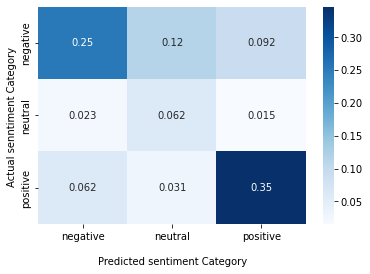

In [14]:
Y_predict = classifier.predict(X_test)
Y_predict = to_categorical(np.argmax(Y_predict, axis=1), 3)
draw_confusion_matrix(Y_predict)

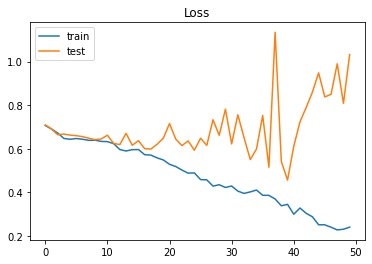

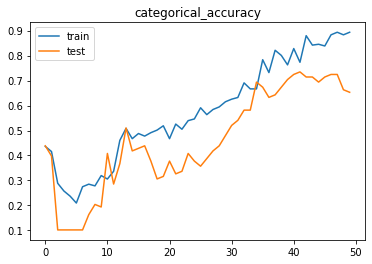

In [15]:
plot(history)

In [16]:
from sklearn.metrics import classification_report

target_names = ["negative" , "neutral" , "positive"]

print(classification_report(Y_test, Y_predict, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.75      0.55      0.63        60
     neutral       0.30      0.62      0.40        13
    positive       0.76      0.79      0.78        57

   micro avg       0.66      0.66      0.66       130
   macro avg       0.60      0.65      0.60       130
weighted avg       0.71      0.66      0.67       130
 samples avg       0.66      0.66      0.66       130



In [40]:
data_test = pd.read_csv('/content/drive/My Drive/thesis/data/processed_data/textual/X_test.csv')
label_test = pd.read_csv('/content/drive/My Drive/thesis/data/processed_data/textual/Y_test.csv')

In [43]:
print(data_test.features[:1])

0    حجم تکالیف مناسب حجم کیفیت تکالیف فعالیت درس ا...
Name: features, dtype: object


In [44]:
label_test[:1]

,0.000000000000000000e+00,0.000000000000000000e+00.1,1.000000000000000000e+00
0,1.0,0.0,0.0


In [17]:
prediction = classifier.predict(X_test[:1])

1/1 [==============================] - 0s 28ms/step


In [19]:
prediction

array([[0.01135487, 0.04646112, 0.942184  ]], dtype=float32)

In [22]:
Y_test[:1]

array([[0., 0., 1.]])